In [2]:
import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

# Cell 4: Visualize one example from each class
def show_class_examples(dataset, class_names_map, samples_per_row=5, num_rows=2):
    """Displays one sample image for each class."""
    if not dataset:
        print("Dataset not loaded. Cannot visualize.")
        return

    num_classes_to_show = len(class_names_map)
    if num_classes_to_show > samples_per_row * num_rows:
        print(f"Warning: Not enough space to show all {num_classes_to_show} classes.")
        num_classes_to_show = samples_per_row * num_rows

    fig, axes = plt.subplots(num_rows, samples_per_row, figsize=(15, 6)) # Adjusted figsize
    axes = axes.ravel() # Flatten the axes array

    split_name = 'train' if 'train' in dataset else list(dataset.keys())[0]
    data_split = dataset[split_name]

    images_shown = 0
    processed_labels = set()

    for i in range(len(data_split)):
        if images_shown >= num_classes_to_show:
            break # Stop once we have shown one for each target class

        example = data_split[i]
        label = example['label']

        if label not in processed_labels and label < num_classes_to_show:
            img = example['image']
            ax_idx = label # Use label directly as index into the flattened axes
            axes[ax_idx].imshow(img)
            axes[ax_idx].set_title(f"Class {label}: {class_names_map[label]}", fontsize=9)
            axes[ax_idx].axis('off')
            processed_labels.add(label)
            images_shown += 1

    # Hide any unused subplots
    for i in range(images_shown, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def evaluate_predictions(predicted_labels, true_labels, class_names_list):
    """
    Calculates and prints classification metrics from predicted labels and true labels.

    Args:
        predicted_labels (list or np.array): The predicted class indices for the test set.
        true_labels (list or np.array): The ground truth class indices for the test set.
        class_names_list (list): A list of strings containing the names of the classes.
    """
    if len(predicted_labels) != len(true_labels):
        print(f"Error: Number of predictions ({len(predicted_labels)}) does not match number of true labels ({len(true_labels)}).")
        return None # Indicate failure

    print(f"Evaluating {len(predicted_labels)} predictions against true labels...")

    # Ensure inputs are numpy arrays for scikit-learn
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Calculate metrics using scikit-learn
    accuracy = accuracy_score(true_labels, predicted_labels)
    # Calculate precision, recall, f1 per class and average (weighted)
    # Use zero_division=0 to handle cases where a class might not be predicted or present in labels
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, average='weighted', zero_division=0
    )
    # Get per-class metrics as well
    per_class_precision, per_class_recall, per_class_f1, per_class_support = precision_recall_fscore_support(
        true_labels, predicted_labels, average=None, zero_division=0, labels=range(len(class_names_list))
    )

    # Generate Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_names_list)))

    # Print Metrics
    print(f"\n--- Evaluation Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    # print(f"Weighted Precision: {precision:.4f}")
    # print(f"Weighted Recall: {recall:.4f}")
    # print(f"Weighted F1-Score: {f1:.4f}")
    # print("-" * 25)
    # print("Per-Class Metrics:")
    # print(f"{'Class':<30} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} | {'Support':<10}")
    # print("-" * 80)
    # for i, name in enumerate(class_names_list):
    #      # Handle cases where support might be 0 for a class in true labels if dataset is small/filtered
    #      support = per_class_support[i] if i < len(per_class_support) else 0
    #      prec = per_class_precision[i] if i < len(per_class_precision) else 0
    #      rec = per_class_recall[i] if i < len(per_class_recall) else 0
    #      f1s = per_class_f1[i] if i < len(per_class_f1) else 0
    #      print(f"{f'{i}: {name}':<30} | {prec:<10.4f} | {rec:<10.4f} | {f1s:<10.4f} | {support:<10}")
    # print("-" * 80)

    # Plot Confusion Matrix
    # print("\nPlotting Confusion Matrix...")
    # fig, ax = plt.subplots(figsize=(10, 10))
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_list)
    # disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    # plt.title('Confusion Matrix')
    # plt.tight_layout() # Adjust layout to prevent overlap
    # plt.show()

    metrics = {
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'confusion_matrix': cm,
        'per_class_metrics': {
            'precision': per_class_precision,
            'recall': per_class_recall,
            'f1': per_class_f1,
            'support': per_class_support
        }
    }
    return metrics

dataset_name = "matthieulel/galaxy10_decals"
galaxy_dataset = datasets.load_dataset(dataset_name)

# Define class names based on the dataset card
class_names = [
    "Disturbed", "Merging", "Round Smooth", "In-between Round Smooth",
    "Cigar Shaped Smooth", "Barred Spiral", "Unbarred Tight Spiral",
    "Unbarred Loose Spiral", "Edge-on without Bulge", "Edge-on with Bulge"
]

# Create a dictionary for easy lookup
label2name = {i: name for i, name in enumerate(class_names)}
name2label = {name: i for i, name in enumerate(class_names)}

num_classes = len(class_names)
print(f"\nNumber of classes: {num_classes}")
print("Class names:", class_names)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
import timm
from timm.data import Mixup
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn


# assume galaxy_dataset, num_classes, class_names and evaluate_predictions are already defined above

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Data transforms
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=360),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.1,  # galaxies aren’t super colorful, so low sat
        hue=0.05
    ),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# 2) Wrap HF dataset with transforms
def apply_train(example):
    return {"pixel_values": [train_transform(ex) for ex in example["image"]], "label": example["label"]}

def apply_eval(example):
    return {"pixel_values": [eval_transform(ex) for ex in example["image"]], "label": example["label"]}

train_ds = galaxy_dataset["train"].with_transform(apply_train)
val_ds   = galaxy_dataset["test"].with_transform(apply_eval)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# 3) Model, loss, optimizer
model = timm.create_model("convnext_large", pretrained=True, num_classes=num_classes, drop_path_rate=0.2)
model.to(device)

mixup_fn = Mixup(mixup_alpha=0.2, cutmix_alpha=0.2, prob=0.4,
                 switch_prob=0.5, mode="batch",
                 label_smoothing=0.0, num_classes=num_classes)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.05)

num_epochs = 20
num_training_steps = num_epochs * len(train_loader)
swa_start_epoch = int(num_epochs * 0.75)

scheduler = LambdaLR(optimizer, lr_lambda=lambda step: max(0.0, 1 - step/num_training_steps))

swa_model = AveragedModel(model)
swa_scheduler = SWALR(optimizer, swa_lr=1e-5)
# 4) Training loop
for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False):
        imgs  = batch["pixel_values"].to(device, non_blocking=True)
        labels= batch["label"].to(device, non_blocking=True)

        imgs, labels = mixup_fn(imgs, labels)

        optimizer.zero_grad()
        with torch.autocast(device_type="cuda"):
            logits = model(imgs)
            loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        if epoch >= swa_start_epoch:
            swa_scheduler.step()
        else:
            scheduler.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch} training loss: {avg_loss:.4f}")

    if epoch >= swa_start_epoch:
        swa_model.update_parameters(model)

    # 5) Validation & metrics
    if epoch >= swa_start_epoch:
        swa_model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                imgs   = batch["pixel_values"].to(device, non_blocking=True)
                labels = batch["label"].to(device, non_blocking=True)
                logits = swa_model(imgs)
                preds  = logits.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
    else:
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                imgs   = batch["pixel_values"].to(device, non_blocking=True)
                labels = batch["label"].to(device, non_blocking=True)
                logits = model(imgs)
                preds  = logits.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    print(f"Validation results after epoch {epoch}:")
    _ = evaluate_predictions(all_preds, all_labels, class_names)
print("Updating BatchNorm statistics for SWA model...")
update_bn(train_loader, swa_model, device=device)

README.md:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

(…)-00000-of-00005-3ac4e3b3fa8df68d.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

(…)-00001-of-00005-72e716d68bb13413.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00002-of-00005-8dd97810f77d7a20.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00003-of-00005-0e1eda89906f6ebb.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00004-of-00005-cbbd007c0641d389.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

(…)-00000-of-00001-cef82967b9d8e57e.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15962 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1774 [00:00<?, ? examples/s]


Number of classes: 10
Class names: ['Disturbed', 'Merging', 'Round Smooth', 'In-between Round Smooth', 'Cigar Shaped Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge']


model.safetensors:   0%|          | 0.00/791M [00:00<?, ?B/s]

Epoch 1/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 1 training loss: 1.0870
Validation results after epoch 1:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8393


Epoch 2/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 2 training loss: 0.8916
Validation results after epoch 2:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8670


Epoch 3/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 3 training loss: 0.8537
Validation results after epoch 3:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8523


Epoch 4/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 4 training loss: 0.7925
Validation results after epoch 4:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8596


Epoch 5/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 5 training loss: 0.7967
Validation results after epoch 5:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8681


Epoch 6/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 6 training loss: 0.7848
Validation results after epoch 6:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8749


Epoch 7/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 7 training loss: 0.7548
Validation results after epoch 7:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8703


Epoch 8/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 8 training loss: 0.7251
Validation results after epoch 8:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8732


Epoch 9/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 9 training loss: 0.7391
Validation results after epoch 9:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8833


Epoch 10/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 10 training loss: 0.6903
Validation results after epoch 10:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8895


Epoch 11/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 11 training loss: 0.6998
Validation results after epoch 11:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8811


Epoch 12/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 12 training loss: 0.6645
Validation results after epoch 12:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8833


Epoch 13/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 13 training loss: 0.6958
Validation results after epoch 13:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8777


Epoch 14/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 14 training loss: 0.6757
Validation results after epoch 14:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8828


Epoch 15/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 15 training loss: 0.6234
Validation results after epoch 15:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8816


Epoch 16/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 16 training loss: 0.6454
Validation results after epoch 16:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8884


Epoch 17/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 17 training loss: 0.6299
Validation results after epoch 17:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8935


Epoch 18/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 18 training loss: 0.6474
Validation results after epoch 18:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8929


Epoch 19/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 19 training loss: 0.6452
Validation results after epoch 19:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8952


Epoch 20/20:   0%|          | 0/499 [00:00<?, ?it/s]

Epoch 20 training loss: 0.6280
Validation results after epoch 20:
Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8946
Updating BatchNorm statistics for SWA model...


In [6]:
def evaluate_predictions(predicted_labels, true_labels, class_names_list):
    """
    Calculates and prints classification metrics from predicted labels and true labels.

    Args:
        predicted_labels (list or np.array): The predicted class indices for the test set.
        true_labels (list or np.array): The ground truth class indices for the test set.
        class_names_list (list): A list of strings containing the names of the classes.
    """
    if len(predicted_labels) != len(true_labels):
        print(f"Error: Number of predictions ({len(predicted_labels)}) does not match number of true labels ({len(true_labels)}).")
        return None # Indicate failure

    print(f"Evaluating {len(predicted_labels)} predictions against true labels...")

    # Ensure inputs are numpy arrays for scikit-learn
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Calculate metrics using scikit-learn
    accuracy = accuracy_score(true_labels, predicted_labels)
    # Calculate precision, recall, f1 per class and average (weighted)
    # Use zero_division=0 to handle cases where a class might not be predicted or present in labels
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, average='weighted', zero_division=0
    )
    # Get per-class metrics as well
    per_class_precision, per_class_recall, per_class_f1, per_class_support = precision_recall_fscore_support(
        true_labels, predicted_labels, average=None, zero_division=0, labels=range(len(class_names_list))
    )

    # Generate Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_names_list)))

    # Print Metrics
    print(f"\n--- Evaluation Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print("-" * 25)
    print("Per-Class Metrics:")
    print(f"{'Class':<30} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} | {'Support':<10}")
    print("-" * 80)
    for i, name in enumerate(class_names_list):
         # Handle cases where support might be 0 for a class in true labels if dataset is small/filtered
         support = per_class_support[i] if i < len(per_class_support) else 0
         prec = per_class_precision[i] if i < len(per_class_precision) else 0
         rec = per_class_recall[i] if i < len(per_class_recall) else 0
         f1s = per_class_f1[i] if i < len(per_class_f1) else 0
         print(f"{f'{i}: {name}':<30} | {prec:<10.4f} | {rec:<10.4f} | {f1s:<10.4f} | {support:<10}")
    print("-" * 80)

    print("\nPlotting Confusion Matrix...")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_list)
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()

    metrics = {
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'confusion_matrix': cm,
        'per_class_metrics': {
            'precision': per_class_precision,
            'recall': per_class_recall,
            'f1': per_class_f1,
            'support': per_class_support
        }
    }
    return metrics


Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8946
Weighted Precision: 0.8945
Weighted Recall: 0.8946
Weighted F1-Score: 0.8932
-------------------------
Per-Class Metrics:
Class                          | Precision  | Recall     | F1-Score   | Support   
--------------------------------------------------------------------------------
0: Disturbed                   | 0.7907     | 0.6239     | 0.6974     | 109       
1: Merging                     | 0.9312     | 0.9514     | 0.9412     | 185       
2: Round Smooth                | 0.9245     | 0.9800     | 0.9515     | 250       
3: In-between Round Smooth     | 0.9265     | 0.9545     | 0.9403     | 198       
4: Cigar Shaped Smooth         | 0.9545     | 0.7500     | 0.8400     | 28        
5: Barred Spiral               | 0.9242     | 0.8986     | 0.9112     | 217       
6: Unbarred Tight Spiral       | 0.7612     | 0.8547     | 0.8053     | 179       
7: Unbarred Loose Spiral       | 0.85

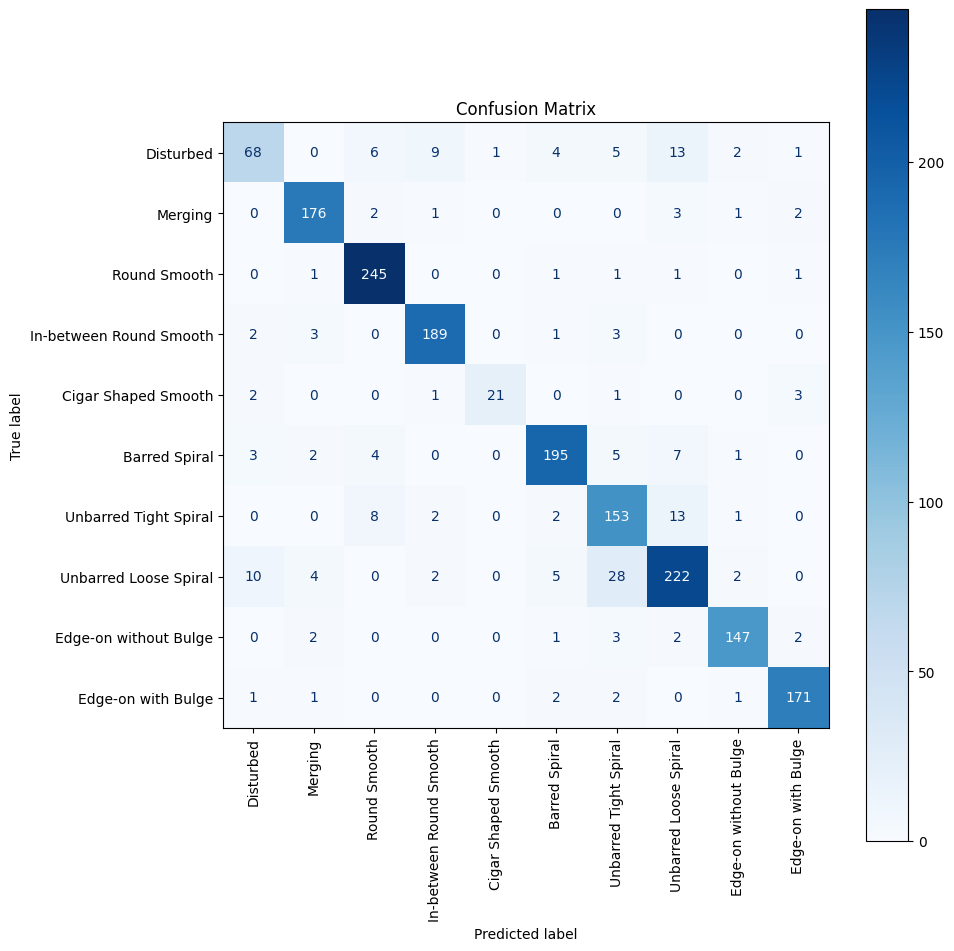

In [8]:
swa_model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        imgs   = batch["pixel_values"].to(device, non_blocking=True)
        labels = batch["label"].to(device, non_blocking=True)
        logits = swa_model(imgs)
        preds  = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
_ = evaluate_predictions(all_preds, all_labels, class_names)